In [16]:
import math
import numpy as np
import pandas as pd
import sys
import re
from functions import *
from mining_functions import *
from collections import Counter
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')

In [17]:
PATH = '/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
def get_path(path = PATH):
    if os.name == 'posix':
        return os.environ['HOME']+path #'/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
    elif os.name == 'nt':
        return os.environ['USERPROFILE']+ path.replace('/','\\') #'\\Google Drive\Jonathan Sarah Ido folder\data\CCK\\'
    else:
        raise Exception('OS not recongnized. I\'m confused.')
gitpath = '/Documents/git/Phet-log-analyzer/cck/raw_data_parsing_check/'
df = pd.read_csv(get_path(path = gitpath) + 'phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
# dfx = pd.read_csv('C:\Users\Sarah\Documents\git\Phet-log-analyzer\cck\\raw_data_parsing_check\phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
df["student"] = df["student"].astype('category')
df["Family"]=df["Family"].str.capitalize()
df["Family_tool"]=df["Family_tool"].str.capitalize()
df["Family_default"]=df["Family_default"].str.capitalize()
df["Family_both"]=df["Family_both"].str.capitalize()

df_scores = pd.read_csv(data_path + 'MATCHING_phet_cck_user_data_anonymized.txt')
df_scores["student"] = df_scores["student"].astype('category')
set(df['Family_both'])

{'Construct',
 'Interface',
 'Pause',
 'Test_basic_noncontactammeter_default',
 'Test_basic_noncontactammeter_not',
 'Test_basic_voltmeter_default',
 'Test_basic_voltmeter_not',
 'Test_complex_noncontactammeter_default',
 'Test_complex_noncontactammeter_not',
 'Test_complex_seriesammeter_default',
 'Test_complex_seriesammeter_not',
 'Test_complex_voltmeter_default',
 'Test_complex_voltmeter_not',
 'Test_other_noncontactammeter_default',
 'Test_other_noncontactammeter_not',
 'Test_other_voltmeter_default',
 'Test_other_voltmeter_not',
 'Test_simple_noncontactammeter_default',
 'Test_simple_noncontactammeter_not',
 'Test_simple_voltmeter_default',
 'Test_simple_voltmeter_not'}

### Functions used to calculate information gain, plot use, etc...

In [31]:
def calc_infogain(data,B,axesnum=None):
    ''' 
    This function calculates the information gain of 2D numpy array. By default, it does not ignore one of the axis.
    
    Arguments:
    data: 2D numpy array
    axesnum: By default, will calculate cumulative information gain over both axes.  
    If 0, then information gain along axis=0 of data is calculated, i.e. for arrangement over time segments over all groups
    If 1, then information gain for arrangement over groups over all time is calculated.
    '''
    max_order_data = np.array([[1.0 for i in range(B)] for j in range(2)])
    entropy = calc_entropy(data,axesnum)
    if axesnum == 0 or axesnum == 1:
        max_entropy = calc_entropy(max_order_data,axesnum)
        infogain = max_entropy - entropy
        if infogain >= 0:
            return infogain
        else:
            raise Exception("Negative infogain.")
    elif axesnum == None:
        max_entropy = calc_entropy(max_order_data)
        infogain = max_entropy - entropy
        if infogain >= 0:
            return infogain
        else:
            raise Exception("Negative infogain.")
    else:
        raise Exception("Invalid value for argument: axesnum can be 0,1 or None ")

        
def plot_heat_map(data, title, ylabels, DisplayXProb = True, DisplayYProb = True, show_cbar=True):

    ''' 
    This function plots a heat map given a 2D numpy array.  The array elements relate 
    to the amount of times a certain sequence of actions is used by students belonging to a 
    certain group at a certain time segment of their activity.
    
    Arguments:
    data: 2D numpy array (data.shape = n*m, where n is len(ylabels) and m is whatever time segment resolution used)
    
    ylabels: list of strings to label the y-axis of heat-map (i.e. the 2 student groups compared)
    By default plot_heat_map will also display the probabilities used in entropy calc corresponding
    to each row and column of data array (on the side of the plot opposite the x/ylabels).
    i.e. probabilities that sequence is used by a certain group over all time 
    and probabilities that sequence is used for a certain time segment over all groups 
    
    show_cbar: show colorbar to the left of plot
    '''

    fig, ax = plt.subplots()
    heatmap = ax.pcolor(data, cmap=plt.cm.Blues, alpha=0.8)

    #set title
    ax.set_title(title,y=1.2)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(data.shape[0]) + 0.5)
    ax.set_xticks(np.arange(data.shape[1]) + 0.5)

    # Set the labels
    xlabels = map(str, np.arange(data.shape[1])+1) 
    ax.set_xticklabels(xlabels, fontweight='bold')
    ax.set_yticklabels(ylabels, fontweight='bold')

    # Create new axes that will show probability that sequence is used by a certain group over all time 
    total = np.sum(data).astype(float) #total number of students that used sequence
    if DisplayXProb == True:
        probx = np.sum(data, axis=0)/total
        xlabels2 = list("%.2f" % px for px in probx)
        ax2 = ax.twiny()
        ax2.xaxis.tick_bottom()
        ax2.invert_yaxis()
        ax2.set_frame_on(False)
        ax2.set_xlim(ax.get_xlim())
        ax2.set_xticks(np.arange(data.shape[1]) + 0.5)
        ax2.set_xticklabels(xlabels2)
        ax2.tick_params(
            axis='x',           # changes apply to both the x and y-axis
            which='both',       # both major and minor ticks are affected
            bottom='off',       # ticks along the those edges are off
            top='off') 

    # Create new axes that will show probability that sequence is used for a certain time segment over all groups 
    if DisplayYProb == True:
        proby = np.sum(data, axis=1)/total
        ylabels3 = list("%.2f" % py for py in proby)
        ax3 = ax.twinx()
        ax3.set_frame_on(False)
        ax3.set_ylim(ax.get_ylim())
        ax3.set_yticks(np.arange(data.shape[0]) + 0.5)
        ax3.set_yticklabels(ylabels3)	
        ax3.tick_params(
            axis='y',           # changes apply to both the x and y-axis
            which='both',       # both major and minor ticks are affected
            right='off',        # ticks along the those edges are off
            left='off') 

    # put time labels on top
    ax.xaxis.tick_top()
    # figure size 
    fig.set_size_inches(8, 2)
    # turn off the frame
    ax.set_frame_on(False)
    # rotate the xticks labels if needed
    # plt.xticks(rotation=90)
    # Turn off all the ticks
    ax.tick_params(
        axis='both',        # changes apply to both the x and y-axis
        which='both',       # both major and minor ticks are affected
        bottom='off',       # ticks along the those edges are off
        right='off', 
        left='off',
        top='off') 
    
    if show_cbar == True: # Add colorbar
        cbaxes = fig.add_axes([1, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
        cbar = fig.colorbar(heatmap, cax=cbaxes)
        cbarticks = [np.amin(data),(np.amin(data)+np.amax(data))/2,np.amax(data)]
        cbar.set_ticks(cbarticks)
        cbar.set_ticklabels(map(str, cbarticks))

def rank_sequences(sequence_counts,B,axesnum=None):
    ranks = []
    for seq,counts in sequence_counts.iteritems():
        if np.sum(counts)>0:
            ranks.append((seq,calc_infogain(counts,B,axesnum)))
    return sorted(ranks, key=lambda tup: tup[1])

def get_top_seqs(ranks,N):
    return ranks[-N:]

### First we get the raw count of unique students using a sequence per time bin

In [44]:
students = get_students()
CUT_OFF_SEQ_USE = 0.2 #we keep only sequences used once by at least 10% of students
N = int(CUT_OFF_SEQ_USE*len(students))
print N
shortest_seq_length = 1
longest_seq_length = 8
B = 5  #number of bins

### PARAMETERS
attribute, level1, level2 = 'learning2','high', 'low'
family_category = 'Family'

sequence_counts = get_sequence_use_by_timebin(df,students,'Family_tool',B,attribute,level1,level2,shortest_seq_length,longest_seq_length,N)
# for k,v in sequence_counts.iteritems():
#     print k,v, np.sum(v)

19
Getting sequence use over 5 time bins for 96 students split by learning2. 
            Keeping only sequences used once by at least 19 students.


### We can calculate the information gain of each sequence by time bin

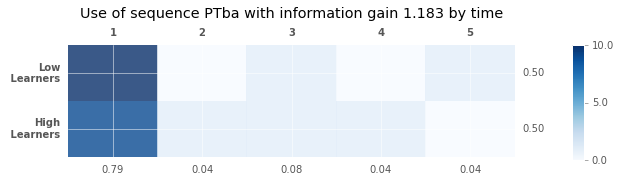

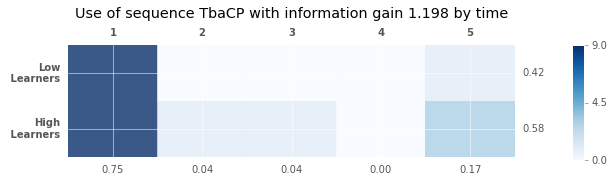

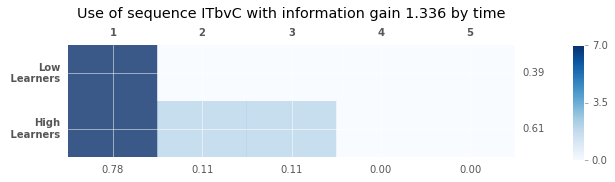

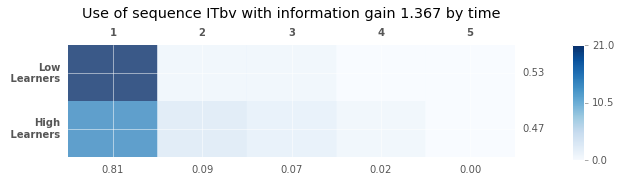

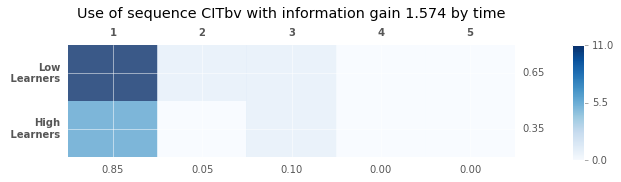

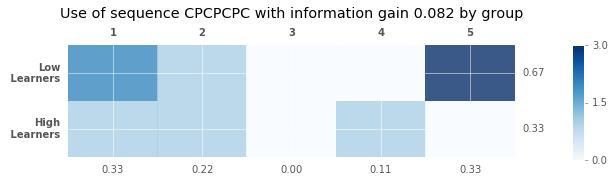

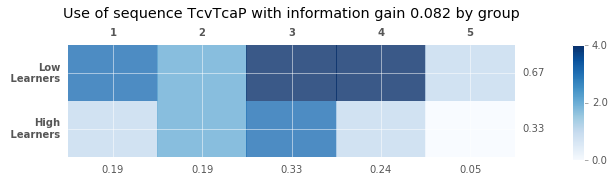

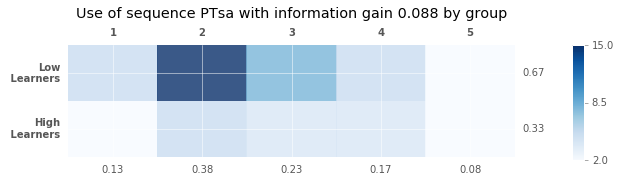

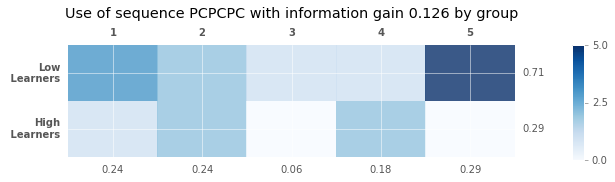

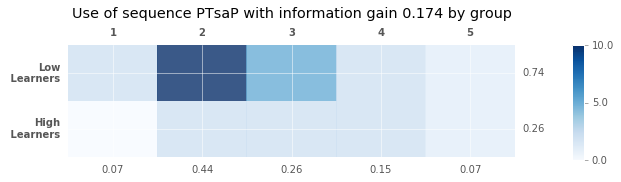

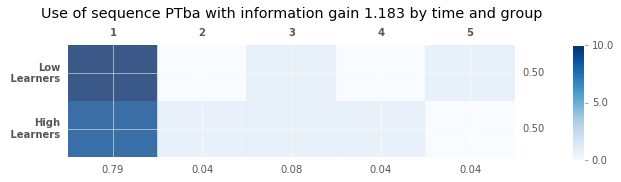

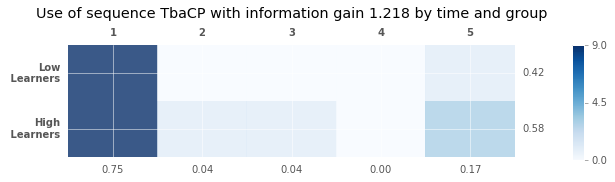

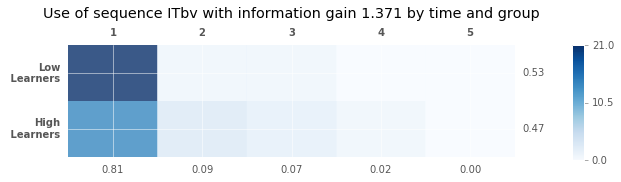

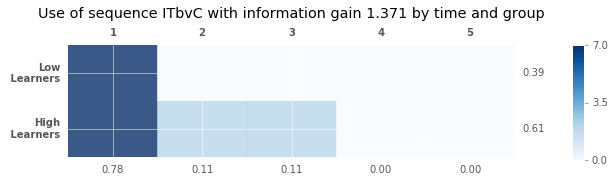

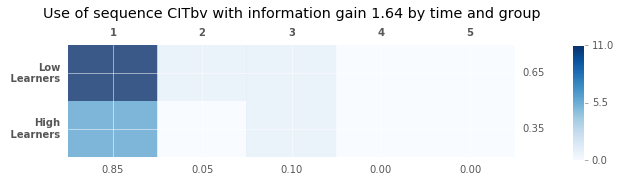

In [45]:
top_seqs_group = get_top_seqs(rank_sequences(sequence_counts,B,1),5)
top_seqs_time = get_top_seqs(rank_sequences(sequence_counts,B,0),5)
top_seqs_both = get_top_seqs(rank_sequences(sequence_counts,B,0),5)

ylabels = ['Low\n Learners', 'High\n Learners']
parse_axis = {0:'time',1:'group',None:'time and group'}
for axis in [0,1,None]:
    tops = get_top_seqs(rank_sequences(sequence_counts,B,axis),5)
    for seq,infogain in tops:
        title = 'Use of sequence {0} with information gain {1} by {2}'.format(seq,round(infogain,3),parse_axis[axis])
        plot_heat_map(sequence_counts[seq],title, ylabels)